In [350]:
import numpy as np 
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from scipy.signal import convolve2d
from scipy.stats import entropy, percentileofscore
from scipy.sparse import bsr_matrix, coo_matrix, dok_array, csr_matrix
from scipy.sparse.linalg import eigs, eigsh
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
import time
import pandas as pd
from sklearn.manifold import TSNE

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 12})

In [351]:
# Load and preprocess data

data = sio.loadmat("./DataSets/TrainImages.mat")['TrainImages']
data = data/255.0

# smoothing
filt = np.ones((3,3))
smooth = np.zeros_like(data)

for i in range(data.shape[0]):
    smooth[i] = convolve2d(data[i], filt, 'same')
    smooth[i] = convolve2d(smooth[i], filt, 'same')
        
# PCA
X = smooth.reshape(60000, 28*28)
X = PCA(n_components=50).fit_transform(X)

In [352]:
# Load labels and convert to one hot
labels = sio.loadmat("./DataSets/TrainImageLabels.mat")['Labels']
labels = np.array(labels, dtype="int").squeeze()
Y = np.copy(labels)

chi = np.eye(10)[Y] # one-hot encode

In [353]:
def construct_adjacency_matrix(X, n, m, sigma):
    # init
    k = X.shape[0]
    W = dok_array((k, k), dtype="float")

    # nearest neighbors
    neigh = NearestNeighbors(n_neighbors=n+1, metric="euclidean").fit(X)
    dists, neighbors = neigh.kneighbors(X, return_distance=True)
    dists_norm = (dists.T/dists[:,m]).T

    # self-tuning distance
    for i in range(k):
        for j in range(1,n+1): #ignore self
            ind = neighbors[i,j]
            # calculate rho_y if not precalculated
            if i in neighbors[ind]:
                p_y = dists_norm[ind, np.argwhere(neighbors[ind]==i)]
            else:
                p_y = np.linalg.norm(X[i]-X[ind])/dists[ind, m]
            W[i, ind] = np.exp(-(dists_norm[i,j]*p_y)/sigma)
            W[ind, i] = np.exp(-(dists_norm[i,j]*p_y)/sigma) # for edge cases where a point is isolated

    # normalize 
    d = W.sum(axis=1)
    K = 1/d * W
    return K

In [354]:
K = construct_adjacency_matrix(X, 9, 4, 1).T

# Diffusion

## Methods

In [355]:
def kernel_smooth(chi, K, k, s, N):
    # select labels
    inds = np.random.choice(np.arange(k), s, replace=False)

    g = np.zeros_like(chi)
    g[inds] = chi[inds]

    for i in range(N):
        for j in range(10):
            g[:,j] = K@g[:,j]

    pred_Y = np.argmax(g, axis=1)
    
    return pred_Y, g

In [356]:
def harm_clf(chi, K, k, s, N):
    # select labels
    inds = np.random.choice(np.arange(k), s, replace=False)

    g = np.zeros_like(chi)
    g[inds] = chi[inds]

    for i in range(N):
        for j in range(10):
            g[:,j] = K@g[:,j]
            g[inds] = chi[inds]

    pred_Y = np.argmax(g, axis=1)
    
    return pred_Y, g

## Cross-Validation

In [357]:
# split into test and train, only use train for CV
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, shuffle=True, random_state=0)

### N

In [358]:
N_list = np.array([10, 12, 15, 17, 20, 30, 50, 75, 100, 150, 200, 250])
N_perf_ks = []

K = construct_adjacency_matrix(X_train, 9, 4, 1).T
chi = np.eye(10)[Y_train]

for i in range(N_list.shape[0]):
    perf = 0
    for j in range(10):          # random sets of labeled points
        np.random.seed(j)
        pred_Y, g = kernel_smooth(chi, K, X_train.shape[0], 100, N_list[i])
        perf += np.mean(pred_Y == Y_train)
    N_perf_ks.append(perf/10)

In [359]:
N_list = np.array([10, 12, 15, 17, 20, 30, 50, 75, 100, 150, 200, 250])
N_perf_hc = []

for i in range(N_list.shape[0]):
    perf = 0
    for j in range(10):          # random sets of labeled points
        np.random.seed(j)
        pred_Y, g = harm_clf(chi, K, X_train.shape[0], 100, N_list[i])
        perf += np.mean(pred_Y == Y_train)
    N_perf_hc.append(perf/10)

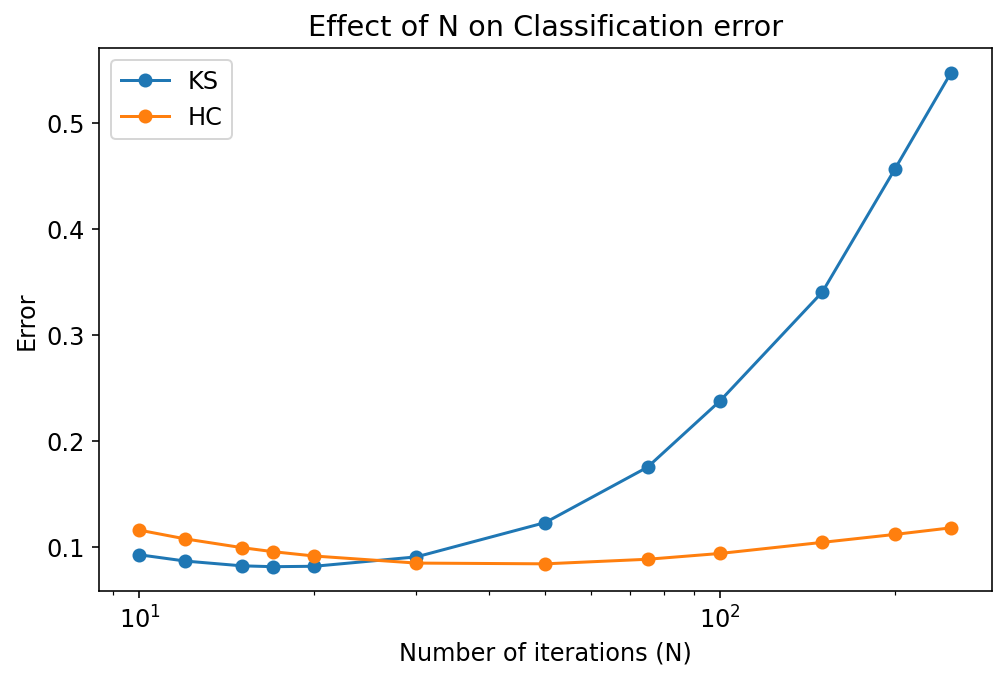

In [369]:
plt.figure(figsize = (8, 5))

plt.plot(N_list, 1-np.array(N_perf_ks), marker="o", label="KS");
plt.plot(N_list, 1-np.array(N_perf_hc), marker="o", label="HC");

plt.xscale("log"); plt.ylabel("Error"); plt.xlabel("Number of iterations (N)");
plt.title("Effect of N on Classification error"); 

plt.legend();
plt.savefig("./figures/project/acc_vs_N.png")

In [362]:
N_ks = N_list[np.argmax(N_perf_ks)]
N_hc = N_list[np.argmax(N_perf_hc)]

In [363]:
N_ks, N_hc

(17, 50)

### n, m

In [364]:
pairs = np.array([(9,4), (13,9), (15,9), (21,15)])
pairs_perf_ks = []
pairs_perf_hc = []

chi = np.eye(10)[Y_train]

for i in range(pairs.shape[0]):
    K = construct_adjacency_matrix(X_train, pairs[i,0], pairs[i,1], 1).T
    perf_ks = 0
    perf_hc = 0
    
    for j in range(10):          # random sets of labeled points
        np.random.seed(j)
        
        pred_Y, g = kernel_smooth(chi, K, X_train.shape[0], 100, N_ks)
        perf_ks += np.mean(pred_Y == Y_train)
        
        pred_Y, g = harm_clf(chi, K, X_train.shape[0], 100, N_hc)
        perf_hc += np.mean(pred_Y == Y_train)
        
    pairs_perf_ks.append(perf_ks/10)
    pairs_perf_hc.append(perf_hc/10)

In [365]:
n_ks, m_ks = pairs[np.argmax(pairs_perf_ks)]
n_hc, m_hc = pairs[np.argmax(pairs_perf_hc)]

In [370]:
1 - np.array(pairs_perf_ks)

array([0.08118333, 0.08452   , 0.08844667, 0.09834667])

In [371]:
1 - np.array(pairs_perf_hc)

array([0.09057   , 0.09755667, 0.10038667, 0.11027   ])

## Effect of # of labeled points

In [18]:
num_tot = np.array([1000, 10000, 30000])
num_lab = np.array([10, 50, 100, 500, 1000, 5000, 15000])
                   
perf_ks = np.zeros((num_tot.shape[0], num_lab.shape[0]))
perf_hc = np.zeros((num_tot.shape[0], num_lab.shape[0]))

for i in range(num_tot.shape[0]):
    inds_tot = np.random.choice(np.arange(X_test.shape[0]), num_tot[i], replace=False)
    K = construct_adjacency_matrix(X_test[inds_tot], n_ks, m_ks, 1).T     # CV gave same n,m for both methods
    chi = np.eye(10)[Y_test[inds_tot]]
    
    
    for j in range(num_lab.shape[0]):
        if (num_lab[j] < num_tot[i]):
            temp_ks = 0
            temp_hc = 0

            for k in range(10):
                np.random.seed(k)

                pred_Y, g = kernel_smooth(chi, K, X_test[inds_tot].shape[0], num_lab[j], N_ks)
                temp_ks += np.mean(pred_Y == Y_test[inds_tot])

                pred_Y, g = harm_clf(chi, K, X_test[inds_tot].shape[0], num_lab[j], N_hc)
                temp_hc += np.mean(pred_Y == Y_test[inds_tot])
            
            perf_ks[i, j] = temp_ks/10
            perf_hc[i, j] = temp_hc/10

In [19]:
plt.rcParams.update({'font.size': 12})

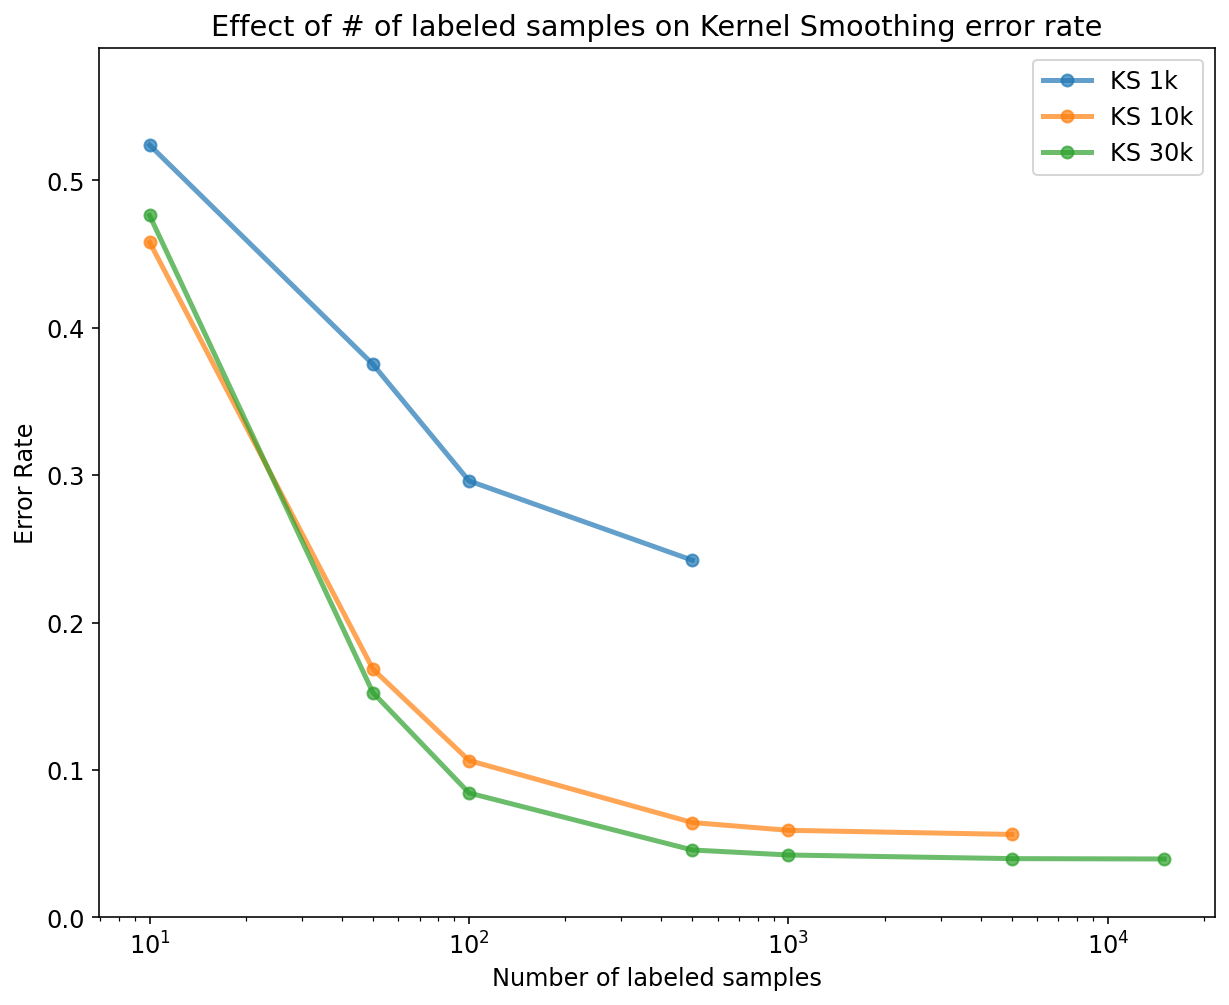

In [20]:
plt.figure(figsize = (10, 8))
plt.plot(num_lab[:4], 1-perf_ks[0,:4], marker="o", label="KS 1k", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:6], 1-perf_ks[1,:6], marker="o", label="KS 10k", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:7], 1-perf_ks[2,:7], marker="o", label="KS 30k", alpha=0.7, linewidth=2.5); plt.xscale("log")

plt.xlabel("Number of labeled samples"); plt.ylabel("Error Rate"); plt.ylim([0, .59])

plt.legend(); plt.title("Effect of # of labeled samples on Kernel Smoothing error rate");

plt.savefig("./figures/project/KS_err_vs_num.png")

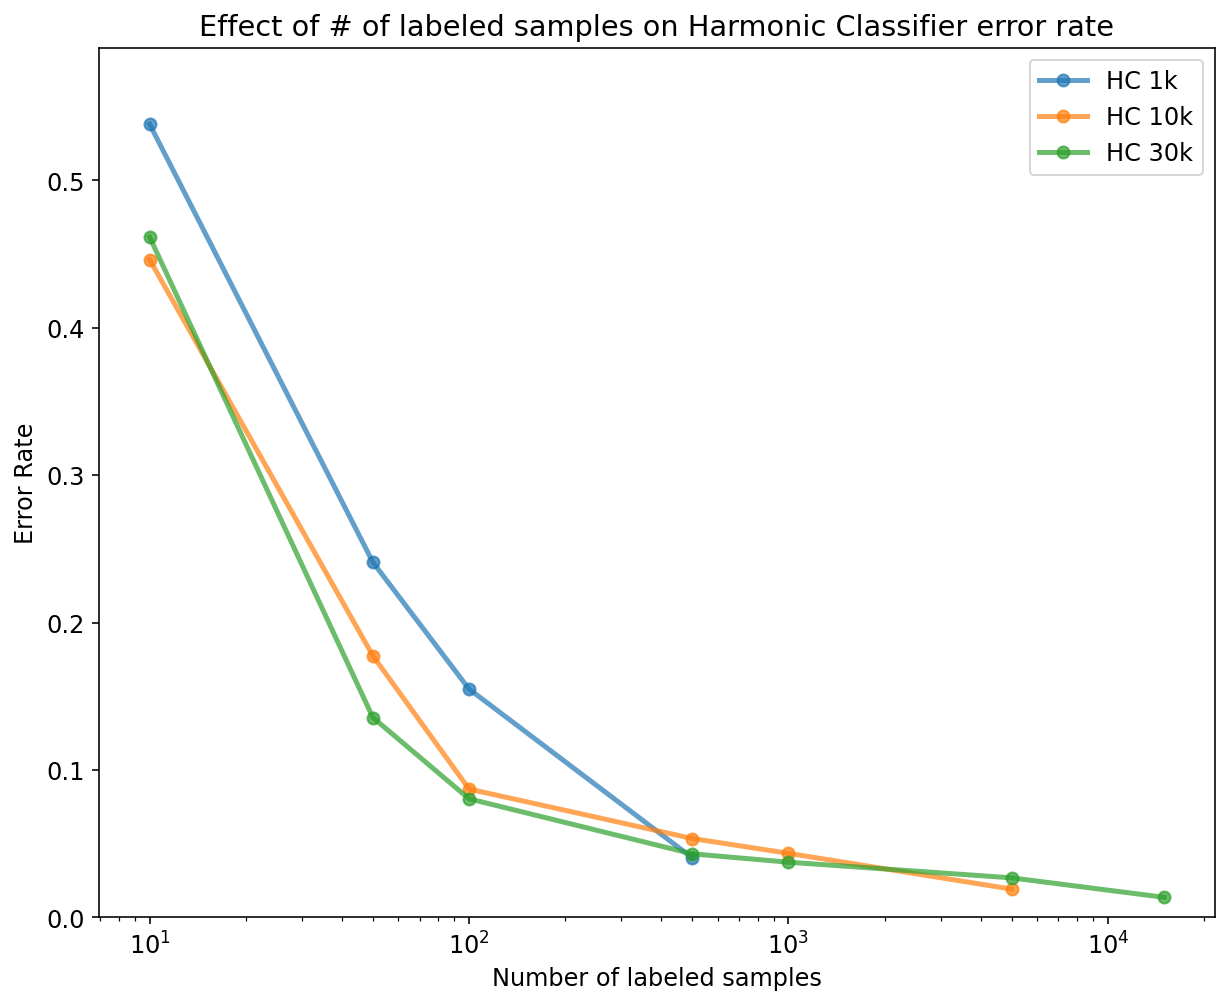

In [21]:
plt.figure(figsize = (10, 8))
plt.plot(num_lab[:4], 1-perf_hc[0,:4], marker="o", label="HC 1k", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:6], 1-perf_hc[1,:6], marker="o", label="HC 10k", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:7], 1-perf_hc[2,:7], marker="o", label="HC 30k", alpha=0.7, linewidth=2.5); plt.xscale("log")

plt.xlabel("Number of labeled samples"); plt.ylabel("Error Rate"); plt.ylim([0, .59])

plt.legend(); plt.title("Effect of # of labeled samples on Harmonic Classifier error rate");

plt.savefig("./figures/project/HC_err_vs_num.png")

# Function Adaptation

## Cross-validation

### beta

In [24]:
beta = np.array([1,2,4,8])
beta_perf_ks = []
beta_perf_hc = []
chi = np.eye(10)[Y_train]

for i in range(beta.shape[0]):
    # run harm_clf for bootstrap estimate
    K = construct_adjacency_matrix(X_train, n_ks, m_ks, 1).T
    perf_ks = 0
    perf_hc = 0
    
    for j in range(10):
        np.random.seed(j)
        pred_Y, g = harm_clf(chi, K, X_train.shape[0], 100, 250)

        # normalize new coords
        c = g/(np.abs(g).sum(axis=0)[np.newaxis,:])
        c *= np.mean(np.linalg.norm(X, axis=1))/np.mean(np.linalg.norm(c, axis=1))
        c *= beta[i]
        
        # run with new X
        X_train_fa = np.hstack((X_train, c))
        K_fa = construct_adjacency_matrix(X_train_fa, n_ks, m_ks, 1).T
        
        pred_Y, g = kernel_smooth(chi, K_fa, X_train_fa.shape[0], 100, N_ks)
        perf_ks += np.mean(pred_Y == Y_train)
        
        pred_Y, g = harm_clf(chi, K_fa, X_train_fa.shape[0], 100, N_hc)
        perf_hc += np.mean(pred_Y == Y_train)
        
    beta_perf_ks.append(perf_ks/10)
    beta_perf_hc.append(perf_hc/10)
    
    print(i)

0
1
2
3


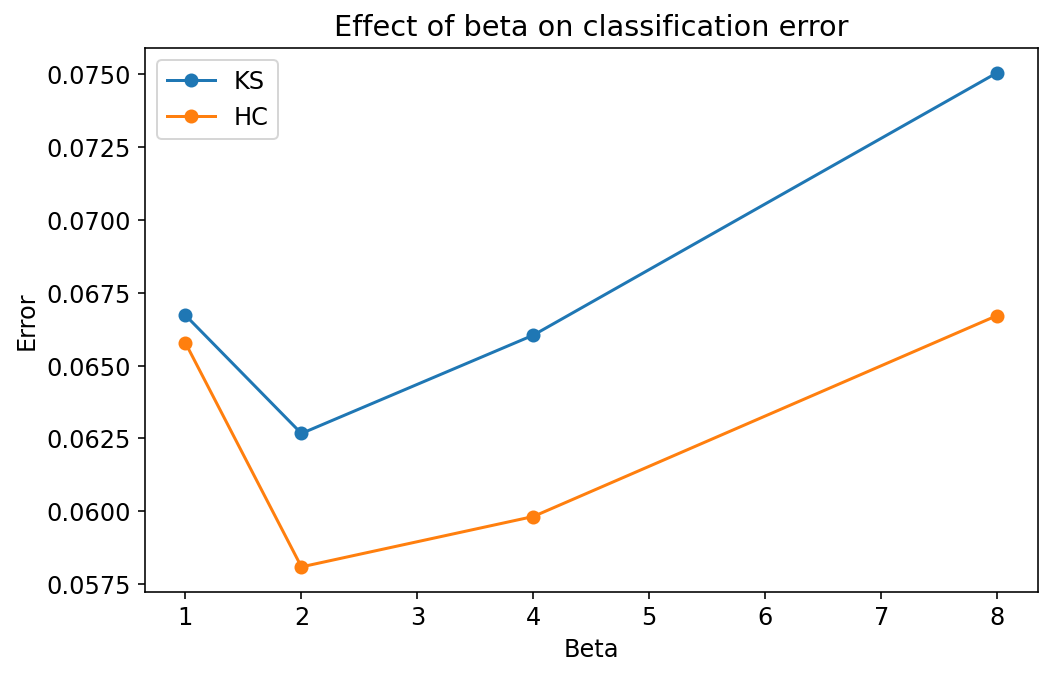

In [372]:
plt.figure(figsize = (8, 5))

plt.plot(beta, 1-np.array(beta_perf_ks), marker="o", label="KS");
plt.plot(beta, 1-np.array(beta_perf_hc), marker="o", label="HC");

plt.ylabel("Error"); plt.xlabel("Beta");
plt.title("Effect of beta on classification error"); 
plt.legend();

plt.savefig("./figures/err_vs_beta.png")

In [373]:
beta_ks = beta[np.argmax(beta_perf_ks)]
beta_hc = beta[np.argmax(beta_perf_hc)]

### N

In [374]:
N_list = np.array([10, 12, 15, 17, 20, 30, 50, 75, 100, 150, 200, 250])
N_perf_ks = []
N_perf_hc = []

K = construct_adjacency_matrix(X_train, 9, 4, 1).T
chi = np.eye(10)[Y_train]

for i in range(N_list.shape[0]):
    # run harm_clf for bootstrap estimate
    K = construct_adjacency_matrix(X_train, n_ks, m_ks, 1).T
    perf_ks = 0
    perf_hc = 0

    for j in range(10):          # random sets of labeled points
        np.random.seed(j)
        pred_Y, g = harm_clf(chi, K, X_train.shape[0], 100, 250)

        # normalize new coords
        c = g/(np.abs(g).sum(axis=0)[np.newaxis,:])
        c *= np.mean(np.linalg.norm(X, axis=1))/np.mean(np.linalg.norm(c, axis=1))
        c *= beta_ks             # beta_ks = beta_hc from CV
        
        # run with new X
        X_train_fa = np.hstack((X_train, c))
        K_fa = construct_adjacency_matrix(X_train_fa, n_ks, m_ks, 1).T
        
        pred_Y, g = kernel_smooth(chi, K_fa, X_train_fa.shape[0], 100, N_list[i])
        perf_ks += np.mean(pred_Y == Y_train)
        
        pred_Y, g = harm_clf(chi, K_fa, X_train_fa.shape[0], 100, N_list[i])
        perf_hc += np.mean(pred_Y == Y_train)
        
    N_perf_ks.append(perf_ks/10)
    N_perf_hc.append(perf_hc/10)

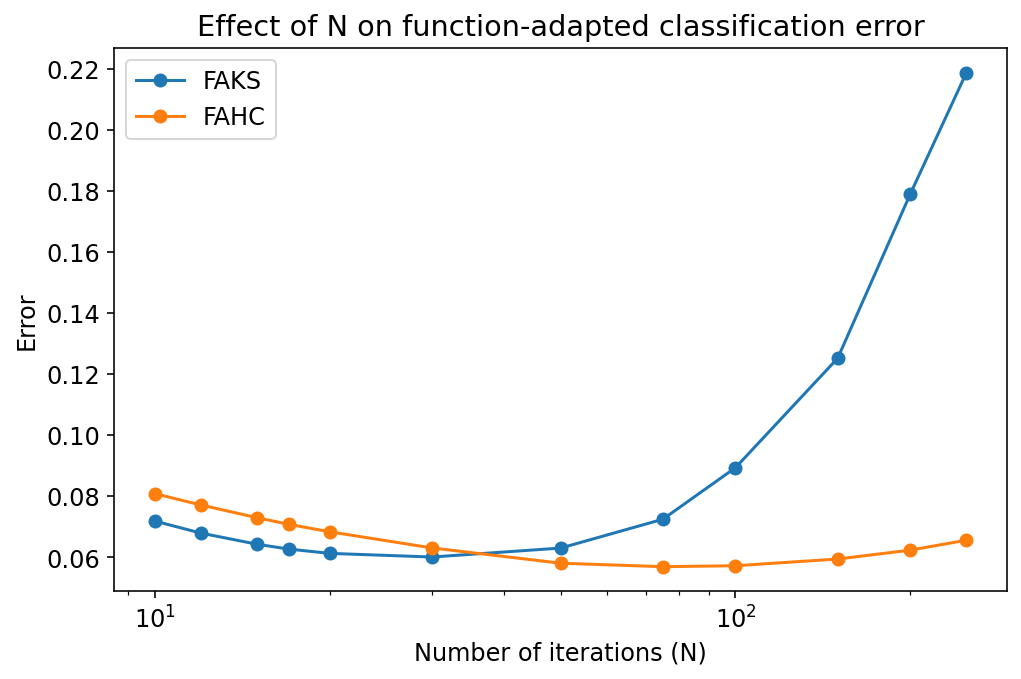

In [381]:
plt.figure(figsize = (8, 5))

plt.plot(N_list, 1-np.array(N_perf_ks), marker="o", label="FAKS");
plt.plot(N_list, 1-np.array(N_perf_hc), marker="o", label="FAHC");

plt.xscale("log"); plt.ylabel("Error"); plt.xlabel("Number of iterations (N)");
plt.title("Effect of N on function-adapted classification error"); 
plt.legend();

plt.savefig("./figures/project/err_vs_N_fa.png")

In [29]:
N_ks_fa = N_list[np.argmax(N_perf_ks)]
N_hc_fa = N_list[np.argmax(N_perf_hc)]

In [30]:
print(N_ks_fa, N_hc_fa)

30 75


### n, m

In [377]:
pairs = np.array([(9,4), (13,9), (15,9), (21,15)])
pairs_perf_ks = []
pairs_perf_hc = []

chi = np.eye(10)[Y_train]

for i in range(pairs.shape[0]):
    K = construct_adjacency_matrix(X_train, pairs[i,0], pairs[i,1], 1).T
    perf_ks = 0
    perf_hc = 0
    
    for j in range(10):          # random sets of labeled points
        np.random.seed(j)
        pred_Y, g = harm_clf(chi, K, X_train.shape[0], 100, 250)

        # normalize new coords
        c = g/(np.abs(g).sum(axis=0)[np.newaxis,:])
        c *= np.mean(np.linalg.norm(X, axis=1))/np.mean(np.linalg.norm(c, axis=1))
        c *= beta_ks             # beta_ks = beta_hc from CV
        
        # run with new X
        X_train_fa = np.hstack((X_train, c))
        K_fa = construct_adjacency_matrix(X_train_fa, pairs[i,0], pairs[i,1], 1).T
        
        pred_Y, g = kernel_smooth(chi, K_fa, X_train_fa.shape[0], 100, N_ks_fa)
        perf_ks += np.mean(pred_Y == Y_train)
        
        pred_Y, g = harm_clf(chi, K_fa, X_train_fa.shape[0], 100, N_hc_fa)
        perf_hc += np.mean(pred_Y == Y_train)
        
    pairs_perf_ks.append(perf_ks/10)
    pairs_perf_hc.append(perf_hc/10)

In [464]:
n_ks_fa, m_ks_fa = pairs[np.argmax(pairs_perf_ks)]
n_hc_fa, m_hc_fa = pairs[np.argmax(pairs_perf_hc)]

In [378]:
1 - np.array(pairs_perf_ks)

array([0.06012667, 0.06322667, 0.06557667, 0.07396667])

In [379]:
1 - np.array(pairs_perf_hc)

array([0.05695667, 0.06040667, 0.06366667, 0.07229667])

## Effect of # of labeled points

In [34]:
num_tot = np.array([1000, 10000, 30000])
num_lab = np.array([10, 50, 100, 500, 1000, 5000, 15000, 30000])
                   
perf_ks = np.zeros((num_tot.shape[0], num_lab.shape[0]))
perf_hc = np.zeros((num_tot.shape[0], num_lab.shape[0]))

for i in range(num_tot.shape[0]):
    # run harm_clf for bootstrap estimate
    inds_tot = np.random.choice(np.arange(X_test.shape[0]), num_tot[i], replace=False)
    K = construct_adjacency_matrix(X_test[inds_tot], n_ks_fa, m_ks_fa, 1).T     # CV gave same n,m for both methods
    chi = np.eye(10)[Y_test[inds_tot]]
    
    for j in range(num_lab.shape[0]):
        if (num_lab[j] < num_tot[i]):
            temp_ks = 0
            temp_hc = 0

            for k in range(10):
                np.random.seed(k)
                pred_Y, g = harm_clf(chi, K, X_test[inds_tot].shape[0], 100, 250)

                # normalize new coords
                c = g/(np.abs(g).sum(axis=0)[np.newaxis,:])
                c *= np.mean(np.linalg.norm(X, axis=1))/np.mean(np.linalg.norm(c, axis=1))
                c *= beta_ks             # beta_ks = beta_hc from CV

                # run with new X
                X_test_fa = np.hstack((X_test[inds_tot], c))
                K_fa = construct_adjacency_matrix(X_test_fa, n_ks_fa, m_ks_fa, 1).T

                pred_Y, g = kernel_smooth(chi, K_fa, X_test_fa.shape[0], num_lab[j], N_ks_fa)
                temp_ks += np.mean(pred_Y == Y_test[inds_tot])

                pred_Y, g = harm_clf(chi, K_fa, X_test_fa.shape[0], num_lab[j], N_hc_fa)
                temp_hc += np.mean(pred_Y == Y_test[inds_tot])
            
            perf_ks[i, j] = temp_ks/10
            perf_hc[i, j] = temp_hc/10

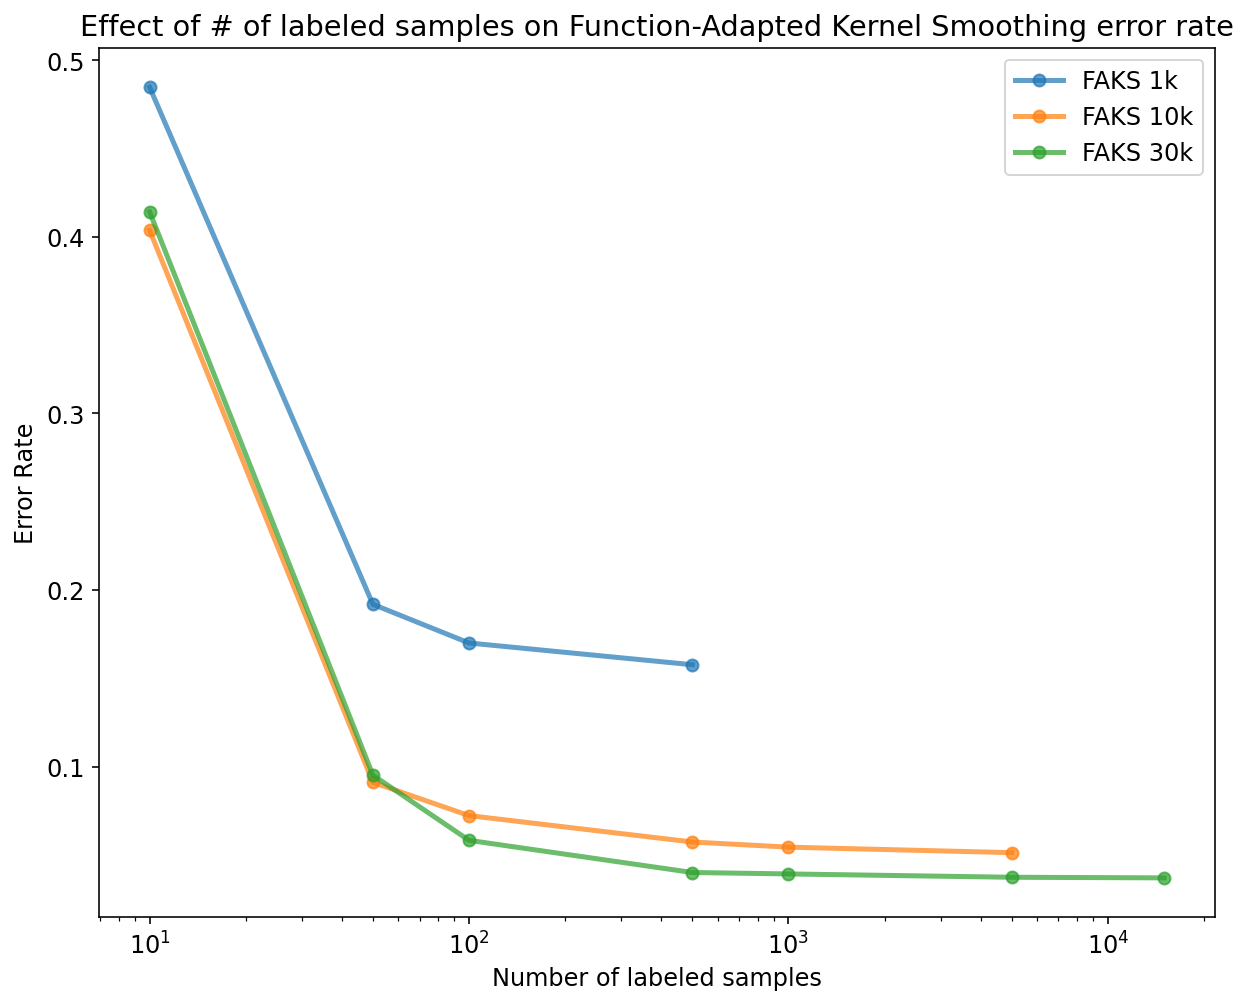

In [35]:
plt.figure(figsize = (10, 8))
plt.plot(num_lab[:4], 1-perf_ks[0,:4], marker="o", label="FAKS 1k", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:6], 1-perf_ks[1,:6], marker="o", label="FAKS 10k", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:7], 1-perf_ks[2,:7], marker="o", label="FAKS 30k", alpha=0.7, linewidth=2.5); plt.xscale("log")

plt.xlabel("Number of labeled samples"); plt.ylabel("Error Rate"); 
# plt.ylim([0, .59])

plt.legend(); plt.title("Effect of # of labeled samples on Function-Adapted Kernel Smoothing error rate");

plt.savefig("./figures/project/FAKS_err_vs_num.png")

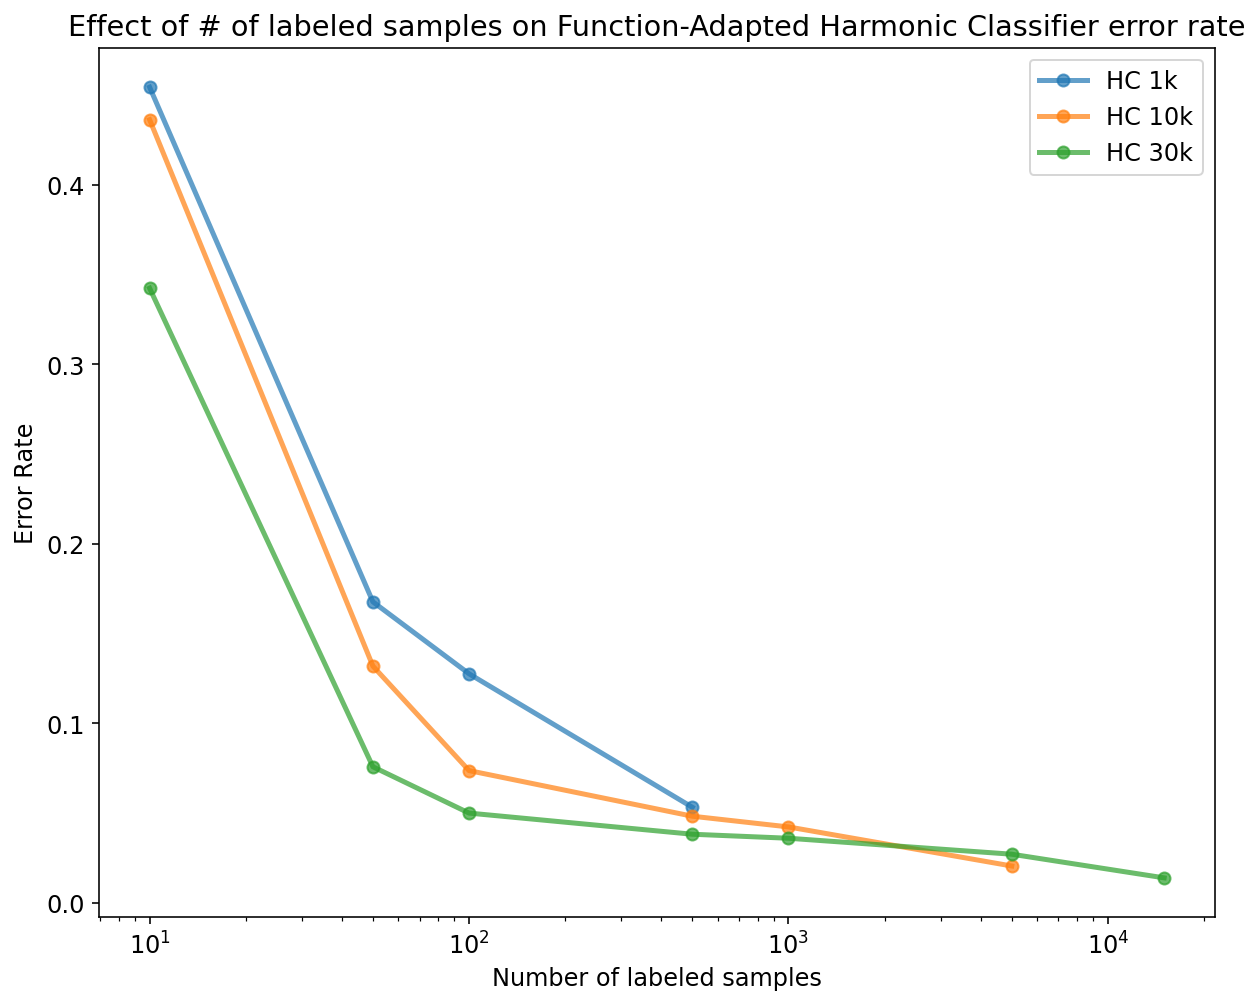

In [37]:
plt.figure(figsize = (10, 8))
plt.plot(num_lab[:4], 1-perf_hc[0,:4], marker="o", label="HC 1k", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:6], 1-perf_hc[1,:6], marker="o", label="HC 10k", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:7], 1-perf_hc[2,:7], marker="o", label="HC 30k", alpha=0.7, linewidth=2.5); plt.xscale("log")

plt.xlabel("Number of labeled samples"); plt.ylabel("Error Rate"); 
# plt.ylim([0, .59])

plt.legend(); plt.title("Effect of # of labeled samples on Function-Adapted Harmonic Classifier error rate");

plt.savefig("./figures/project/FAHC_err_vs_num.png")

# Active Learning

## Methods

In [40]:
def al_kernel_smooth(chi, inds, K, N):
    g = np.zeros_like(chi)
    g[inds] = chi[inds]

    for i in range(N):
        for j in range(10):
            g[:,j] = K@g[:,j]

    pred_Y = np.argmax(g, axis=1)
    
    return pred_Y, g

In [68]:
def al_harm_clf(chi, inds, K, N):

    g = np.zeros_like(chi)
    g[inds] = chi[inds]

    for i in range(N):
        for j in range(10):
            g[:,j] = K@g[:,j]
            g[inds] = chi[inds]

    pred_Y = np.argmax(g, axis=1)
    
    return pred_Y, g

## Cross-Validation

In [272]:
metric.argsort()

array([24216, 29200, 26480, ...,  3175, 12851, 24199])

In [275]:
metric.argsort()[-50:]

array([ 2849, 21453, 28338, 13257, 14047, 29138,  6048,  2734, 26868,
       28598, 17269, 23596, 26979, 12756, 25091, 15747, 22842,  3852,
        3045, 17353, 21560,  9389, 25814, 17321, 27879, 10571,  9684,
       22347, 22429, 12682, 18013, 17498,  8556,  6934, 17675, 24585,
       29979, 14836, 25419,  1422, 12624,  4473, 27776,  4655,  8622,
       19082, 13090,  3175, 12851, 24199])

### isolation nn

In [284]:
nn_list = np.array([2, 3, 5, 10, 20, 50, 100, 200])

iso_perf_ks = []
iso_perf_hc = []

K = construct_adjacency_matrix(X_train, 9, 4, 1).T
chi = np.eye(10)[Y_train]

for i in range(nn_list.shape[0]):
    perf_ks = 0
    perf_hc = 0
    
    neigh = NearestNeighbors(n_neighbors=nn_list[i], metric="euclidean").fit(X_train)
    dists, neighbors = neigh.kneighbors(X_train, return_distance=True)
    conn = 1/np.median(dists[:, 1:], axis=1)

    for j in range(10):          # random sets of labeled points
        np.random.seed(j)
        inds = np.random.choice(np.arange(X_train.shape[0]), 50, replace=False)
        temp = inds.copy()
        
        # kernel smoothing
        pred_Y, g = al_kernel_smooth(chi, inds, K, N_ks)
        S = entropy(g, axis=1)
        metric = conn * S
        
        met[neighbors[inds]] = 0   # don't want to repick already labelled
        for k in range(5):
            pred_Y, g = al_kernel_smooth(chi, inds, K, N_ks)
            S = entropy(g, axis=1)
            metric = conn * S
            inds = np.concatenate((inds, metric.argsort()[-10:]))
            
        pred_Y, g = al_kernel_smooth(chi, inds, K, N_ks)
        perf_ks += np.mean(pred_Y == Y_train)
        
        # harmonic 
        inds = temp.copy()
        pred_Y, g = al_harm_clf(chi, inds, K, N_hc)
        S = entropy(g, axis=1)
        metric = conn * S
        
        met[neighbors[inds]] = 0   # don't want to repick already labelled
        for k in range(5):
            pred_Y, g = al_harm_clf(chi, inds, K, N_hc)
            S = entropy(g, axis=1)
            metric = conn * S
            inds = np.concatenate((inds, metric.argsort()[-10:]))
            
        pred_Y, g = al_kernel_smooth(chi, inds, K, N_hc)
        perf_hc += np.mean(pred_Y == Y_train)
        
    iso_perf_ks.append(perf_ks/10)
    iso_perf_hc.append(perf_hc/10)

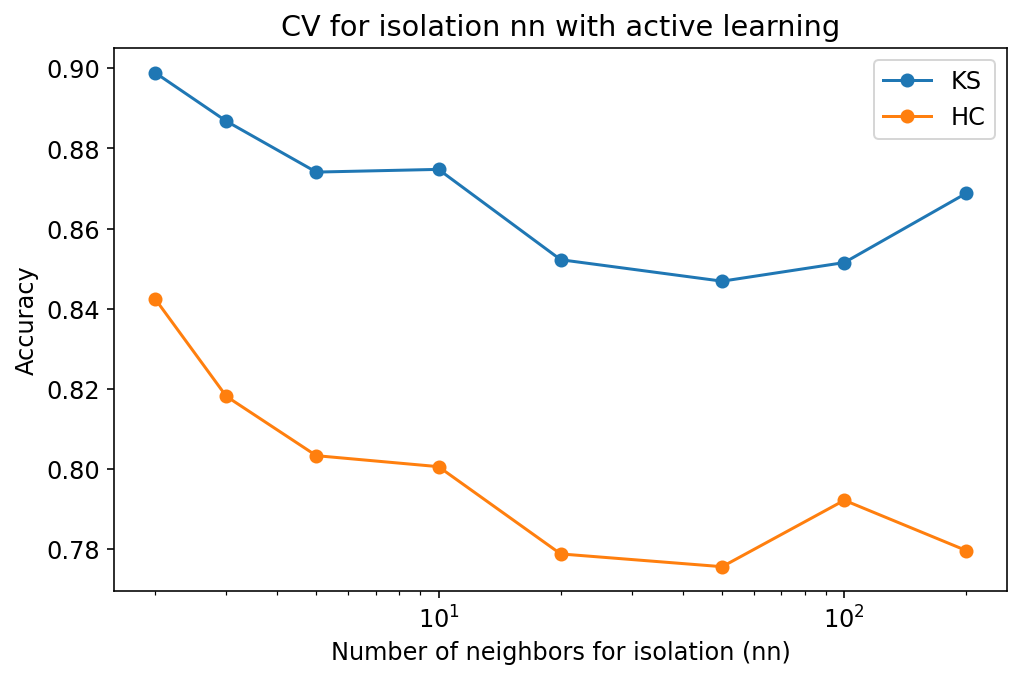

In [285]:
plt.figure(figsize = (8, 5))

plt.plot(nn_list, iso_perf_ks, marker="o", label="KS");
plt.plot(nn_list, iso_perf_hc, marker="o", label="HC");

plt.xscale("log"); plt.ylabel("Accuracy"); plt.xlabel("Number of neighbors for isolation (nn)");
plt.title("CV for isolation nn with active learning"); 
plt.legend();

# Runtime

## Graph construction

In [389]:
num_samples = [50, 100, 500, 1000, 5000, 10000]
graph_times = np.zeros(len(num_samples))
tot_times = np.zeros(len(num_samples))

for i in range(len(num_samples)):
    X_short = X[:num_samples[i]]
    chi = np.eye(10)[Y[:num_samples[i]]]
    start = time.time()
    
    K = construct_adjacency_matrix(X_short, 9, 4, 1).T
    graph_stop = time.time()
    
    pred_Y, g = kernel_smooth(chi, K, X_short.shape[0], 10, N_ks)
    
    stop = time.time()
    
    graph_times[i] = graph_stop - start
    tot_times[i] = stop - start
    

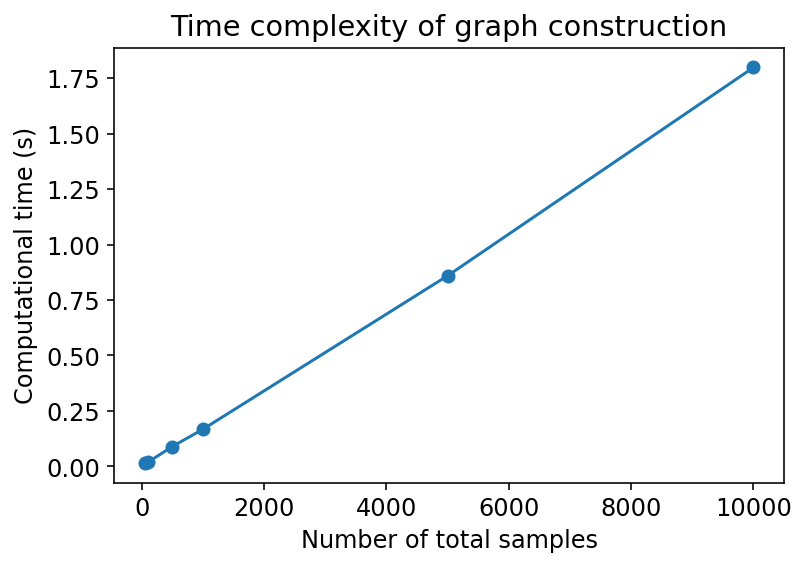

In [390]:
plt.plot(num_samples, graph_times, marker="o"); plt.ylabel("Computational time (s)"); plt.xlabel("Number of total samples"); plt.title("Time complexity of graph construction");

plt.savefig("./figures/project/graph_comp.png")

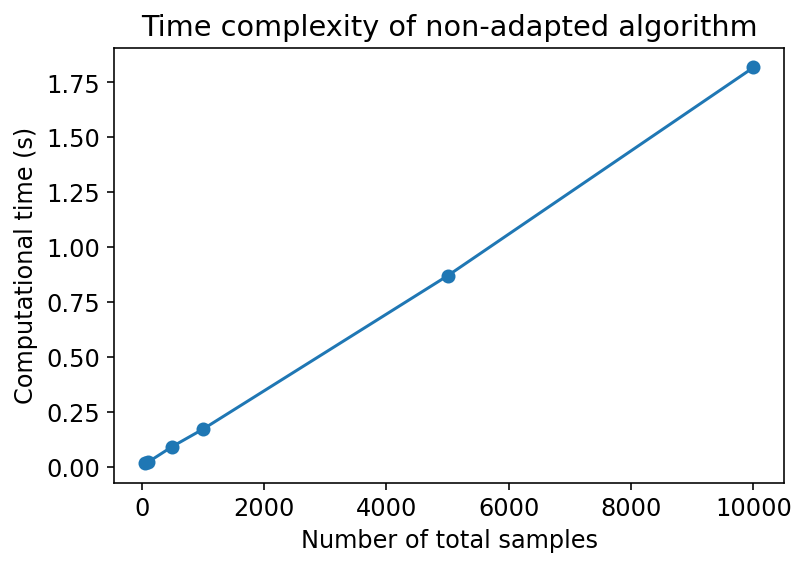

In [391]:
plt.plot(num_samples, tot_times, marker="o"); plt.ylabel("Computational time (s)"); plt.xlabel("Number of total samples"); plt.title("Time complexity of non-adapted algorithm");
plt.savefig("./figures/project/nonfa_comp.png")

In [ ]:
num_samples = [50, 100, 500, 1000, 5000, 10000]
graph_times = np.zeros(len(num_samples))
tot_times = np.zeros(len(num_samples))

for i in range(len(num_samples)):
    X_short = X[:num_samples[i]]
    chi = np.eye(10)[Y[:num_samples[i]]]
    start = time.time()
    
    K = construct_adjacency_matrix(X_short, 9, 4, 1).T
    graph_stop = time.time()
    
    
    pred_Y, g = harm_clf(chi, K, X_short.shape[0], 50, 250)

    # normalize new coords
    c = g/(np.abs(g).sum(axis=0)[np.newaxis,:])
    c *= np.mean(np.linalg.norm(X_short, axis=1))/np.mean(np.linalg.norm(c, axis=1))
    c *= 2         # beta_ks = beta_hc from CV

    # run with new X
    X_train_fa = np.hstack((X_short, c))
    K_fa = construct_adjacency_matrix(X_train_fa, n_ks, m_ks, 1).T

    pred_Y, g = kernel_smooth(chi, K_fa, X_train_fa.shape[0], 50, 30)
    
    stop = time.time()
    
    graph_times[i] = graph_stop - start
    tot_times[i] = stop - start
    

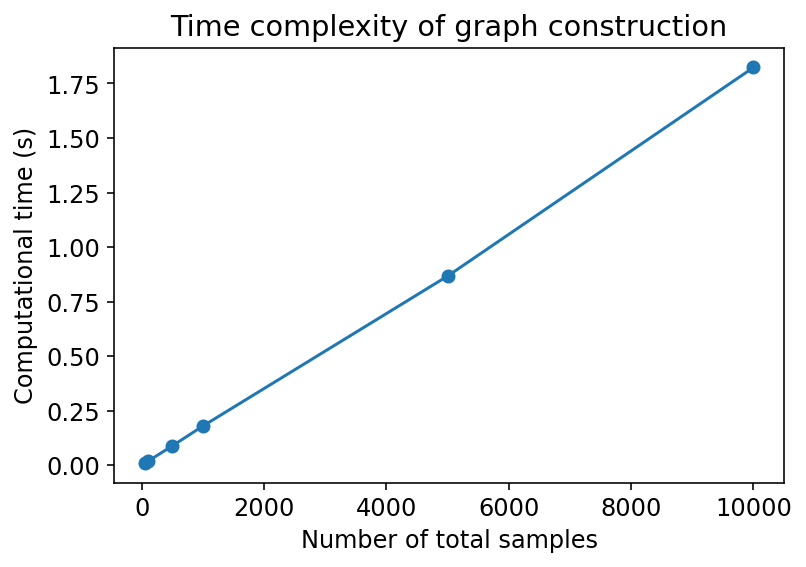

In [395]:
plt.plot(num_samples, graph_times, marker="o"); plt.ylabel("Computational time (s)"); plt.xlabel("Number of total samples"); plt.title("Time complexity of graph construction");

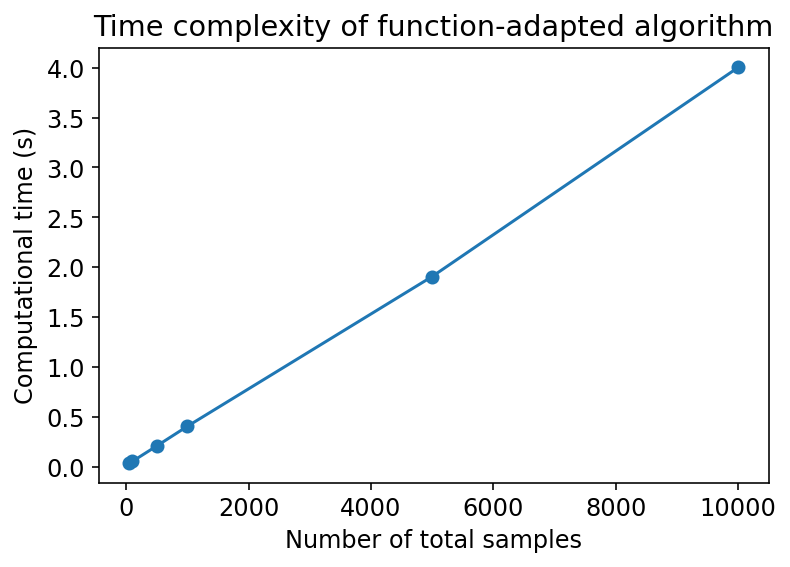

In [396]:
plt.plot(num_samples, tot_times, marker="o"); plt.ylabel("Computational time (s)");

plt.xlabel("Number of total samples"); plt.title("Time complexity of function-adapted algorithm");
plt.savefig("./figures/project/fa_comp.png")

# TSNE

In [329]:
x_tsne = TSNE().fit_transform(X)

/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [342]:
df = pd.DataFrame({"tsne_1": x_tsne[:,0],
                   "tsne_2": x_tsne[:,1],
                   "class": Y})

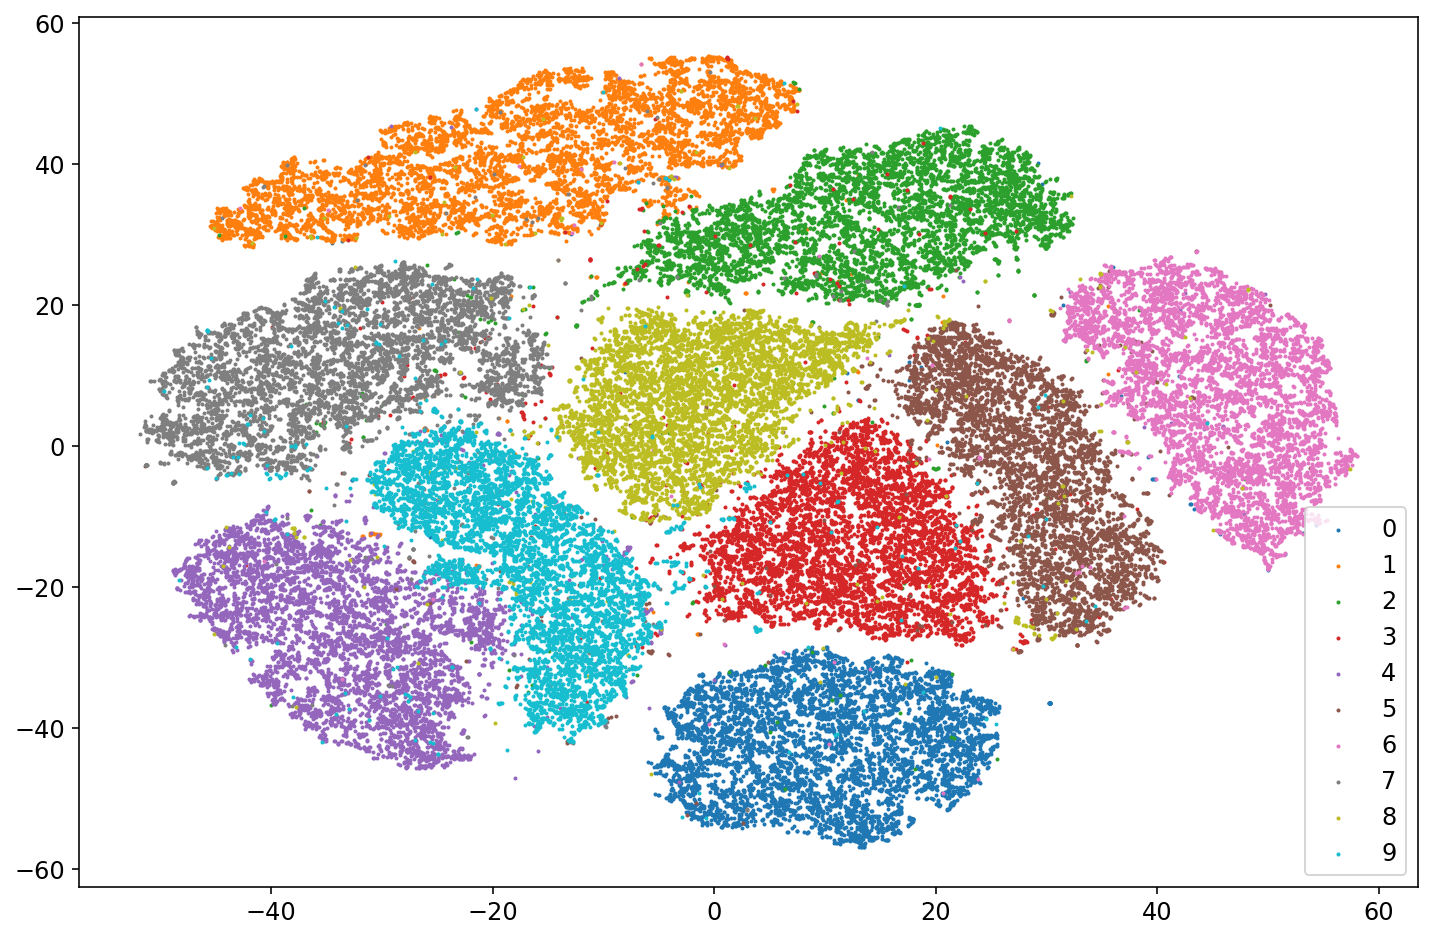

In [348]:
groups = df.groupby("class")

plt.figure(figsize=(12,8))
for name, group in groups:
    plt.scatter(group.tsne_1, group.tsne_2, s=1, label=name)
    
plt.legend();